This kernel implements 2 DL models for coreference resolution. All the model in this kernel are Non-RNN Based DL models.

Features extraction used in this kernel follows Clark and Mannings work: https://nlp.stanford.edu/pubs/clark2016improving.pdf
If you are interested in RNN based End2End coreference solution model, please check this kernel: https://www.kaggle.com/keyit92/end2end-coref-resolution-by-attention-rnn.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import gc
print(os.listdir("../input"))

from spacy.lang.en import English
from spacy.pipeline import DependencyParser
import spacy
from nltk import Tree
from category_encoders.one_hot import OneHotEncoder
from gensim.models import Word2Vec
import time

import numpy as np
from keras import backend
from keras import layers
from keras import models
from keras import initializers, regularizers, constraints, activations
from keras.engine import Layer
import keras.backend as K
from keras.layers import merge
from keras import callbacks as kc
from keras import optimizers as ko
from keras import initializers, regularizers, constraints
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, train_test_split
import sklearn.metrics as skm

# Any results you write to the current directory are saved as output.
#plt.ioff()

['gendered-pronoun-resolution', 'gap-data', 'gap-coreference']


Using TensorFlow backend.


In [2]:
def measure_log_loss(ground, preds):
    preds = preds.tolist()
    return skm.log_loss(ground, preds, labels=[0, 1, 2], eps=10**-15)

In [3]:
def add_results(df, probs):
    df.loc[:, 'A'] = pd.Series(probs[:, 0])
    df.loc[:, 'B'] = pd.Series(probs[:, 1])
    df.loc[:, 'NEITHER'] = pd.Series(probs[:, 2])
    
def drop_results(df):
    df.drop(columns=['A', 'B', 'NEITHER'], inplace=True)

# Import Data

In [4]:
DATA_ROOT = '../input/'
GAP_DATA_FOLDER = os.path.join(DATA_ROOT, 'gap-data')

df_path1 = os.path.join(GAP_DATA_FOLDER, 'gap-phase1.csv')
df_path2 = os.path.join(GAP_DATA_FOLDER, 'gap-phase2.csv')

df = pd.read_csv(df_path1)
test_df = pd.read_csv(df_path2)

# split development data
dev_size = 454
dev_df = df.iloc[:dev_size]
train_df = df.iloc[dev_size:].reset_index()

In [5]:
print(df.shape)
df.head()

(4454, 11)


,ID,Text,Pronoun,Pronoun-offset,A,A-offset,A-coref,B,B-offset,B-coref,URL
0,development-636,"In 2001, it was performed at the Royal Festiva...",her,281,John,209,False,Bob,273,True,http://en.wikipedia.org/wiki/George_Stiles
1,test-1300,"Charles Gore Bob, 20th Earl of John and 3rd Ba...",his,241,John,185,True,Bob,213,False,"http://en.wikipedia.org/wiki/Charles_Hay,_20th..."
2,development-1247,Lester and Davis shared some crucial scenes in...,he,434,John,347,False,Bob,404,True,http://en.wikipedia.org/wiki/Bruce_Lester
3,development-1559,"This is about getting Apple healthy, and this ...",he,375,John,220,False,Bob,274,True,http://en.wikipedia.org/wiki/Stevenote
4,development-1957,Bob is also very proud of the liner note her i...,she,259,John,188,False,Bob,205,True,http://en.wikipedia.org/wiki/Erin_Hay


In [6]:
print(train_df.shape)
train_df.head()

(4000, 12)


,index,ID,Text,Pronoun,Pronoun-offset,A,A-offset,A-coref,B,B-offset,B-coref,URL
0,454,validation-222,She informs Will and Roz Washington (NeNe Leak...,his,367,John,241,False,Bob,334,True,"http://en.wikipedia.org/wiki/Love,_Love,_Love_..."
1,455,development-1069,It is generally accepted that he was the first...,he,359,John,300,True,Bob,323,False,http://en.wikipedia.org/wiki/Carl_Wilhelm_Scheele
2,456,validation-360,The two women are shocked to see each other an...,her,277,John,243,True,Bob,256,False,http://en.wikipedia.org/wiki/Aventurera
3,457,development-1831,"The film was Fox's first real talkie, using th...",her,259,John,241,True,Bob,252,False,http://en.wikipedia.org/wiki/Mother_Knows_Best...
4,458,development-1735,In what she describes as ``a moment of artisti...,her,277,John,291,True,Bob,319,False,http://en.wikipedia.org/wiki/Maisie_Dobbs_(novel)


# Explore Features for Building Mention-Pair Distributed Representation

## Embedding Features

Follow the idea from the work by Clark and Manning, extract word embedding of head word, dependency parent, first word, last word, two preceding words and two following words of the mention.  Average word embeding of the five preceding words, five following words, all words in the mention, all words in the sentences.

In [7]:
nlp = spacy.load('en_core_web_lg', disable=['tagger', 'ner', 'textcat'])

### Parse Text

In [8]:
def bs_(list_, target_):
    lo, hi = 0, len(list_) -1
    
    while lo < hi:
        mid = lo + int((hi - lo) / 2)
        
        if target_ < list_[mid]:
            hi = mid
        elif target_ > list_[mid]:
            lo = mid + 1
        else:
            return mid
    return lo

def ohe_dist(dist, buckets):
    idx = bs_(buckets, dist)
    oh = np.zeros(shape=(len(buckets),), dtype=np.float32)
    oh[idx] = 1
    
    return oh

In [9]:
def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_

def bs(list_, target_):
    lo, hi = 0, len(list_) -1
    
    while lo < hi:
        mid = lo + int((hi - lo) / 2)
        
        if target_ < list_[mid]:
            hi = mid
        elif target_ > list_[mid]:
            lo = mid + 1
        else:
            return mid + 1
    return lo

def _get_preceding_words(tokens, offset, k):
    start = offset - k
    
    precedings = [None] * max(0, 0-start)
    start = max(0, start)
    precedings += tokens[start: offset]
    
    return precedings

def _get_following_words(tokens, offset, k):
    end = offset + k
    
    followings = [None] * max(0, end - len(tokens))
    end = min(len(tokens), end)
    followings += tokens[offset: end]
    
    return followings
        

def extrac_embed_features_tokens(text, char_offset):
    doc = nlp(text)
    
    # char offset to token offset
    lens = [token.idx for token in doc]
    mention_offset = bs(lens, char_offset) - 1
    # mention_word
    mention = doc[mention_offset]
    
    # token offset to sentence offset
    lens = [len(sent) for sent in doc.sents]
    acc_lens = [len_ for len_ in lens]
    pre_len = 0
    for i in range(0, len(acc_lens)):
        pre_len += acc_lens[i]
        acc_lens[i] = pre_len
    sent_index = bs(acc_lens, mention_offset)
    # mention sentence
    sent = list(doc.sents)[sent_index]
    
    # dependency parent
    head = mention.head
    
    # last word and first word
    first_word, last_word = sent[0], sent[-2]
    
    assert mention_offset >= 0
    
    # two preceding words and two following words
    tokens = list(doc)
    precedings2 = _get_preceding_words(tokens, mention_offset, 2)
    followings2 = _get_following_words(tokens, mention_offset, 2)
    
    # five preceding words and five following words
    precedings5 = _get_preceding_words(tokens, mention_offset, 5)
    followings5 = _get_following_words(tokens, mention_offset, 5)
    
    # sentence words
    sent_tokens = [token for token in sent]
    
     # buckets
    bucket_pos = [0, 1, 2, 3, 4, 5, 8, 16, 32]
    # absolute position in the sentence
    sent_pos = mention_offset
    if sent_index > 0:
        sent_pos = mention_offset - acc_lens[sent_index-1]
    sent_pos_oh = ohe_dist(sent_pos, bucket_pos)
    sent_pos_inv = len(sent) - sent_pos - 1
    assert sent_pos_inv >= 0
    sent_pos_inv_oh = ohe_dist(sent_pos_inv, bucket_pos)
    
    return mention, head, first_word, last_word, precedings2, followings2, precedings5, followings5, sent_tokens, sent_pos_oh, sent_pos_inv_oh

Example:

In [10]:
print("Texts: ")
text = test_df.iloc[0]['Text']
print(text)

print("\nFeatures:")
mention, parent, first_word, last_word, precedings2, followings2, precedings5, followings5, sent_tokens, sent_pos_oh, sent_pos_inv_oh = extrac_embed_features_tokens(text, test_df.iloc[0]['A-offset'])
features = pd.Series([str(feature) for feature in (mention, parent, first_word, last_word, precedings2, followings2, precedings5, followings5, sent_tokens, sent_pos_oh, sent_pos_inv_oh)], index=['mention', 'parent', 'first_word', 'last_word', 'precedings2', 'followings2', 'precedings5', 'followings5', 'sent_tokens', 'sent_pos_oh', 'sent_pos_inv_oh'])
features

print(mention.vector.shape)

Texts: 
Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played John, Bob's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Bob.

Features:
(300,)


### Generate Embedding Features

In [11]:
num_embed_features = 11
embed_dim = 300

In [12]:
def spacy_feats(tokens):
    feats = list()
    for token in tokens:
        if token is None:
            feats += ["na", "na", "na", "na"]
            continue
        feats += [token.dep_, token.shape_, str(token.is_alpha), str(token.is_stop)]
    return feats

def token_vector(token):
    return token.vector if token.has_vector else np.zeros((embed_dim,))

def token_vector_mean(tokens):
    if len(tokens) == 0:
        return np.zeros((embed_dim,))
    
    x_ = np.zeros((embed_dim,))
    num = 0
    for token in tokens:
        if token is not None and token.has_vector:
            x_ += token.vector
            num += 1
    return x_ if num <= 1 else x_ / num

def create_embedding_features(df, text_column, offset_column):
    text_offset_list = df[[text_column, offset_column]].values.tolist()
    num_features = num_embed_features
    
    embed_feature_matrix_list = list()
    other_features = list()
    pos_features = list()
    for text_offset_index in range(len(text_offset_list)):
        text_offset = text_offset_list[text_offset_index]
        mention, parent, first_word, last_word, precedings2, followings2, precedings5, followings5, sent_tokens, sent_pos_oh, sent_pos_inv_oh = extrac_embed_features_tokens(text_offset[0], text_offset[1])
        
        embed_feature_matrix_list.append(list())
        embed_feature_matrix_list[-1].append(token_vector(mention))
        embed_feature_matrix_list[-1].append(token_vector(parent))
        embed_feature_matrix_list[-1].append(token_vector(first_word))
        embed_feature_matrix_list[-1].append(token_vector(last_word))
        embed_feature_matrix_list[-1] += [token_vector(token) if token is not None else np.zeros((embed_dim,)) for token in precedings2]
        embed_feature_matrix_list[-1] += [token_vector(token) if token is not None else np.zeros((embed_dim,)) for token in followings2]
        embed_feature_matrix_list[-1].append(token_vector_mean(precedings5))
        embed_feature_matrix_list[-1].append(token_vector_mean(followings5))
        embed_feature_matrix_list[-1].append(token_vector_mean(sent_tokens))
        embed_feature_matrix_list[-1] = np.stack(tuple(embed_feature_matrix_list[-1]))
        
        other_features.append(list())
        other_features[-1] += spacy_feats([mention, parent, first_word, last_word])
        other_features[-1] += spacy_feats(precedings2)
        other_features[-1] += spacy_feats(followings2)
        
        pos_features.append(np.concatenate((sent_pos_oh, sent_pos_inv_oh)))
    
    return np.stack(tuple(embed_feature_matrix_list)), other_features, np.asarray(pos_features)

 ##  Position Features

Encode the absolute positions in the sentence and the relative position between the pronoun and the entities.

In [13]:
def extrac_positional_features(text, char_offset1, char_offset2):
    doc = nlp(text)
    max_len = 64
    
    # char offset to token offset
    lens = [token.idx for token in doc]
    mention_offset1 = bs(lens, char_offset1) - 1
    mention_offset2 = bs(lens, char_offset2) - 1
    
    # token offset to sentence offset
    lens = [len(sent) for sent in doc.sents]
    acc_lens = [len_ for len_ in lens]
    pre_len = 0
    for i in range(0, len(acc_lens)):
        pre_len += acc_lens[i]
        acc_lens[i] = pre_len
    sent_index1 = bs(acc_lens, mention_offset1)
    sent_index2 = bs(acc_lens, mention_offset2)
    
    sent1 = list(doc.sents)[sent_index1]
    sent2 = list(doc.sents)[sent_index2]
    
    # buckets
    bucket_dist = [1, 2, 3, 4, 5, 8, 16, 32, 64]
    
    # relative distance
    dist = mention_offset2 - mention_offset1
    dist_oh = ohe_dist(dist, bucket_dist)
    
    return dist_oh

In [14]:
num_pos_features = 9

In [15]:
def create_dist_features(df, text_column, pronoun_offset_column, name_offset_column):
    text_offset_list = df[[text_column, pronoun_offset_column, name_offset_column]].values.tolist()
    num_features = num_pos_features
    
    pos_feature_matrix = np.zeros(shape=(len(text_offset_list), num_features))
    for text_offset_index in range(len(text_offset_list)):
        text_offset = text_offset_list[text_offset_index]
        dist_oh = extrac_positional_features(text_offset[0], text_offset[1], text_offset[2])
        
        feature_index = 0
        pos_feature_matrix[text_offset_index, feature_index:feature_index+len(dist_oh)] = np.asarray(dist_oh)
        feature_index += len(dist_oh)
    
    return pos_feature_matrix

### Generate Training, Validation and Testing Data

In [16]:
p_emb_tra, p_feats_tra, p_pos_tra = create_embedding_features(train_df, 'Text', 'Pronoun-offset')
p_emb_dev, p_feats_dev, p_pos_dev = create_embedding_features(dev_df, 'Text', 'Pronoun-offset')
p_emb_test, p_feats_test, p_pos_test = create_embedding_features(test_df, 'Text', 'Pronoun-offset')

a_emb_tra, a_feats_tra, a_pos_tra = create_embedding_features(train_df, 'Text', 'A-offset')
a_emb_dev, a_feats_dev, a_pos_dev = create_embedding_features(dev_df, 'Text', 'A-offset')
a_emb_test, a_feats_test, a_pos_test = create_embedding_features(test_df, 'Text', 'A-offset')

b_emb_tra, b_feats_tra, b_pos_tra = create_embedding_features(train_df, 'Text', 'B-offset')
b_emb_dev, b_feats_dev, b_pos_dev = create_embedding_features(dev_df, 'Text', 'B-offset')
b_emb_test, b_feats_test, b_pos_test = create_embedding_features(test_df, 'Text', 'B-offset')

pa_dist_tra = create_dist_features(train_df, 'Text', 'Pronoun-offset', 'A-offset')
pa_dist_dev = create_dist_features(dev_df, 'Text', 'Pronoun-offset', 'A-offset')
pa_dist_test = create_dist_features(test_df, 'Text', 'Pronoun-offset', 'A-offset')

pb_dist_tra = create_dist_features(train_df, 'Text', 'Pronoun-offset', 'B-offset')
pb_dist_dev = create_dist_features(dev_df, 'Text', 'Pronoun-offset', 'B-offset')
pb_dist_test = create_dist_features(test_df, 'Text', 'Pronoun-offset', 'B-offset')

In [17]:
# One hot encode other features
feats_encoder = OneHotEncoder(return_df=False)
feats_encoder.fit(
    p_feats_tra + p_feats_dev + p_feats_test + a_feats_tra + a_feats_dev + a_feats_test + b_feats_tra + b_feats_dev + b_feats_test
)

p_encode_tra = np.concatenate((feats_encoder.transform(p_feats_tra), p_pos_tra), axis=1)
a_encode_tra = np.concatenate((feats_encoder.transform(a_feats_tra), a_pos_tra), axis=1)
b_encode_tra = np.concatenate((feats_encoder.transform(b_feats_tra), b_pos_tra), axis=1)

p_encode_test = np.concatenate((feats_encoder.transform(p_feats_test), p_pos_test), axis=1)
a_encode_test = np.concatenate((feats_encoder.transform(a_feats_test), a_pos_test), axis=1)
b_encode_test = np.concatenate((feats_encoder.transform(b_feats_test), b_pos_test), axis=1)

p_encode_dev = np.concatenate((feats_encoder.transform(p_feats_dev), p_pos_dev), axis=1)
a_encode_dev = np.concatenate((feats_encoder.transform(a_feats_dev), a_pos_dev), axis=1)
b_encode_dev = np.concatenate((feats_encoder.transform(b_feats_dev), b_pos_dev), axis=1)

In [18]:
def _row_to_y(row):
    if row.loc['A-coref']:
        return 0
    if row.loc['B-coref']:
        return 1
    return 2

y_train = train_df.apply(_row_to_y, axis=1)
y_dev = dev_df.apply(_row_to_y, axis=1)
y_test = test_df.apply(_row_to_y, axis=1)

In [19]:
X_train = [p_emb_tra, a_emb_tra, b_emb_tra, p_encode_tra, a_encode_tra, b_encode_tra, pa_dist_tra, pb_dist_tra]
X_dev = [p_emb_dev, a_emb_dev, b_emb_dev, p_encode_dev, a_encode_dev, b_encode_dev, pa_dist_dev, pb_dist_dev]
X_test = [p_emb_test, a_emb_test, b_emb_test, p_encode_test, a_encode_test, b_encode_test, pa_dist_test, pb_dist_test]

# Build and Train Model

## Flat MLP

In [20]:
model_name = "flatmlp_glove"

In [21]:
def build_flatmlp_model(
    num_channels1, num_channels2, num_channels3, 
    num_features1, num_features2, num_features3, 
    feature_dim1, output_dim, model_dim, mlp_dim, 
    mlp_depth=1, embed_dropout=0.5, drop_out=0.2, 
    return_customized_layers=False):

    # inputs
    inputs1 = list()
    for fi in range(num_channels1):
        inputs1.append(models.Input(shape=(num_features1, feature_dim1), dtype='float32', name='input1_' + str(fi)))
        
    inputs2 = list()
    for fi in range(num_channels2):
        inputs2.append(models.Input(shape=(num_features2,), dtype='float32', name='input2_' + str(fi)))
        
    inputs3 = list()
    for fi in range(num_channels3):
        inputs3.append(models.Input(shape=(num_features3,), dtype='float32', name='input3_' + str(fi)))
        
    features1_pip = models.Sequential()
    #features1_pip.add(layers.TimeDistributed(layers.Dropout(rate=embed_dropout, name="embed_dropout_layer")))
    features1_pip.add(layers.Flatten(name="embed_flatten_layer"))
    x1 = [features1_pip(input_) for input_ in inputs1]
    x2 = inputs2
    x3 = inputs3
    
    concate_layer = layers.Concatenate(axis=1, name="concate_layer")
    xpa = concate_layer([x1[0], x1[1], x2[0], x2[1], x3[0]])
    xpb = concate_layer([x1[0], x1[2], x2[0], x2[2], x3[1]])
    
    # MLP Layers
    dropout_layer = layers.Dropout(rate=embed_dropout, name="dropout_layer")
    map_layer = layers.Dense(model_dim, activation='relu', kernel_initializer='lecun_normal', name='relu_layer')
    xpa = dropout_layer(xpa)
    xpa = map_layer(xpa)
    xpb = dropout_layer(xpb)
    xpb = map_layer(xpb)
    
    x = layers.Concatenate(axis=1, name="embed_concate_layer")([xpa, xpb])
    x = layers.Dropout(rate=drop_out, name="embed_dropout_layer")(x)
        
    for i in range(mlp_depth - 1):
        x = layers.Dense(mlp_dim, activation='selu', kernel_initializer='lecun_normal', name='selu_layer' + str(i))(x)
        x = layers.AlphaDropout(drop_out, name='alpha_layer' + str(i))(x)

    outputs = layers.Dense(output_dim, activation="softmax", name="softmax_layer0")(x)

    model = models.Model(inputs1 + inputs2 + inputs3, outputs)

    if return_customized_layers:
        return model, {}

    return model

### Build Model 

In [22]:
num_channels1 = 3
num_channels2 = 3
num_channels3 = 2
num_features1 = p_emb_tra.shape[1]
num_features2 = p_encode_tra.shape[1]
#num_features2 = p_pos_tra.shape[1]
num_features3 = pa_dist_tra.shape[1]
feature_dim1 = p_emb_tra.shape[2]
output_dim = 3
model_dim = 12
mlp_dim = 12
mlp_depth=1
embed_dropout=0.6
drop_out=0.0
return_customized_layers=False
n_fold = 5
epochs = 1000

In [23]:
# Training and cross-validation
dummy_X = np.zeros(shape=(train_df.shape[0], 1))

folds = KFold(n_splits=n_fold, shuffle=False, random_state=3)
is_first_fold = True
preds_train = list()
preds_dev = None
preds_test = None
for fold_n, (train_index, val_index) in enumerate(folds.split(dummy_X)):
    # split training and validation data
    print('Fold', fold_n, 'started at', time.ctime())
    
    Xt = [XX[train_index] for XX in X_train]
    Xv = [XX[val_index] for XX in X_train]
    
    yt = y_train.values[train_index]
    yv = y_train.values[val_index]
    
    model = build_flatmlp_model(
    num_channels1, num_channels2, num_channels3, 
    num_features1, num_features2, num_features3, 
    feature_dim1, output_dim, model_dim, mlp_dim, 
    mlp_depth=mlp_depth, embed_dropout=embed_dropout, drop_out=drop_out, 
    return_customized_layers=return_customized_layers
    )
    
    adam = ko.Nadam()
    model.compile(adam, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

    early_stop = kc.EarlyStopping(monitor = "val_loss", mode = "min", patience=3, restore_best_weights=True)
    history = model.fit(Xt, yt, epochs=epochs, validation_data=(Xv, yv), callbacks = [early_stop], verbose=0, batch_size=32)
    
    preds_train_tmp = model.predict(Xv)
    preds_dev_tmp = model.predict(X_dev)
    preds_test_tmp = model.predict(X_test)
    
    print("single model train loss: ")
    print(history.history['loss'][-1])
    print("single model validation loss: ")
    print(measure_log_loss(yv, preds_train_tmp))
    print("single model dev loss: ")
    print(measure_log_loss(y_dev.values, preds_dev_tmp))
    
    
    fig = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    #plt.show()
    fig.savefig(model_name + '_lossplot.png')
    plt.close(fig)
    
    if is_first_fold:
        preds_train.append(preds_train_tmp)
        preds_dev = preds_dev_tmp
        preds_test = preds_test_tmp
    else:
        preds_train.append(preds_train_tmp)
        preds_dev += preds_dev_tmp
        preds_test += preds_test_tmp
        
    is_first_fold = False

preds_train = np.concatenate(preds_train)
preds_dev /= n_fold
preds_test /= n_fold
print("cv model accuracy: ")
print(measure_log_loss(y_dev.values, preds_dev))

add_results(train_df, preds_train)
add_results(dev_df, preds_dev)
add_results(test_df, preds_test)
train_file_name = model_name + "_train.csv"
dev_file_name = model_name + "_dev.csv"
test_file_name = model_name + "_test.csv"

train_df.to_csv(train_file_name, index=False)
dev_df.to_csv(dev_file_name, index=False)
test_df.to_csv(test_file_name, index=False)

drop_results(train_df)
drop_results(dev_df)
drop_results(test_df)

Fold 0 started at Thu Apr 11 08:57:03 2019
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
single model train loss: 
0.49591844737529756
single model validation loss: 
0.6749488700638594
single model dev loss: 
0.6570429825191484
Fold 1 started at Thu Apr 11 08:57:12 2019
single model train loss: 
0.4424515211582184
single model validation loss: 
0.6344608131527979
single model dev loss: 
0.6331661897295825
Fold 2 started at Thu Apr 11 08:57:17 2019
single model train loss: 
0.5219307124614716
single model validation loss: 
0.680560342796911
single model dev loss: 
0.6586009870673192
Fold 3 started at Thu Apr 11 08:57:21 2019
single model train loss: 
0.45024380266666414
single model validation loss: 
0.648848530971577
single model dev loss: 
0.6479055217436238
Fold 4 started at Thu Apr 11 08:57:26 201

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

## Mapped MLP

In [24]:
model_name = "mapmlp_glove"

In [25]:
def build_mapmlp_model(
    num_channels1, num_channels2, num_channels3, 
    num_features1, num_features2, num_features3, 
    feature_dim1, output_dim, model_dim1, model_dim2, mlp_dim, 
    mlp_depth=1, embed_dropout1=0.5, embed_dropout2=0.5, drop_out=0.2, 
    return_customized_layers=False):

    # inputs
    inputs1 = list()
    for fi in range(num_channels1):
        inputs1.append(models.Input(shape=(num_features1, feature_dim1), dtype='float32', name='input1_' + str(fi)))
        
    inputs2 = list()
    for fi in range(num_channels2):
        inputs2.append(models.Input(shape=(num_features2,), dtype='float32', name='input2_' + str(fi)))
        
    inputs3 = list()
    for fi in range(num_channels3):
        inputs3.append(models.Input(shape=(num_features3,), dtype='float32', name='input3_' + str(fi)))
        
    features1_pip = models.Sequential()
    features1_pip.add(layers.TimeDistributed(layers.Dropout(rate=embed_dropout1, name="embed_dropout_layer1")))
    features1_pip.add(layers.TimeDistributed(layers.Dense(model_dim, activation='relu', kernel_initializer='lecun_normal', name='relu_layer1')))
    features1_pip.add(layers.Flatten(name="embed_flatten_layer"))
    x1 = [features1_pip(input_) for input_ in inputs1]
    
    concate_layer = layers.Concatenate(axis=1, name="concate_layer")
    x23 = concate_layer(inputs2 + inputs3)
    
    features2_pip = models.Sequential()
    features2_pip.add(layers.Dropout(rate=embed_dropout2, name="embed_dropout_layer2"))
    features2_pip.add(layers.Dense(model_dim, activation='relu', kernel_initializer='lecun_normal', name='relu_layer2'))
    x23 = features2_pip(x23)
    
    x = layers.Concatenate(axis=1, name="embed_concate_layer")(x1 + [x23,])
    x = layers.Dropout(rate=drop_out, name="embed_dropout_layer")(x)
        
    for i in range(mlp_depth - 1):
        x = layers.Dense(mlp_dim, activation='selu', kernel_initializer='lecun_normal', name='selu_layer' + str(i))(x)
        x = layers.AlphaDropout(drop_out, name='alpha_layer' + str(i))(x)

    outputs = layers.Dense(output_dim, activation="softmax", name="softmax_layer0")(x)

    model = models.Model(inputs1 + inputs2 + inputs3, outputs)

    if return_customized_layers:
        return model, {}

    return model

In [26]:
num_channels1 = 3
num_channels2 = 3
num_channels3 = 2
num_features1 = p_emb_tra.shape[1]
num_features2 = p_encode_tra.shape[1]
#num_features2 = p_pos_tra.shape[1]
num_features3 = pa_dist_tra.shape[1]
feature_dim1 = p_emb_tra.shape[2]
output_dim = 3
model_dim1 = 10
model_dim2 = 20
mlp_dim = 12
mlp_depth=1
embed_dropout1=0.6
embed_dropout2=0.6
drop_out=0.1
return_customized_layers=False
n_fold = 5
epochs = 1000

Fold 0 started at Thu Apr 11 08:57:32 2019
single model train loss: 
0.5462740111351013
single model validation loss: 
0.66107965694602
single model dev loss: 
0.649046494175064


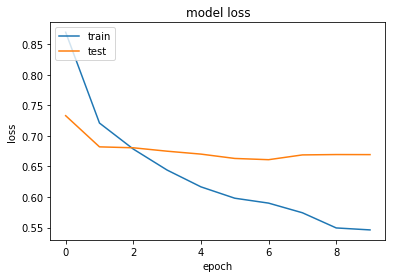

Fold 1 started at Thu Apr 11 08:57:40 2019
single model train loss: 
0.5551864898204804
single model validation loss: 
0.6284896684291058
single model dev loss: 
0.6403082400273308


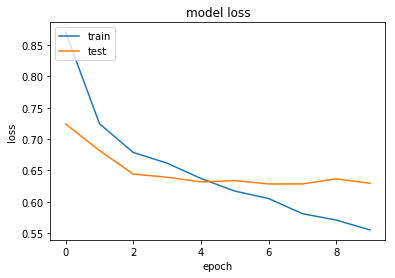

Fold 2 started at Thu Apr 11 08:57:49 2019
single model train loss: 
0.5663361710309982
single model validation loss: 
0.6958751396730084
single model dev loss: 
0.6448832212626392


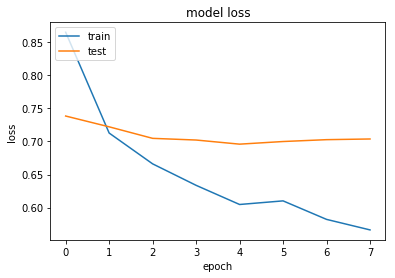

Fold 3 started at Thu Apr 11 08:57:57 2019
single model train loss: 
0.5513182091712951
single model validation loss: 
0.6369707501117213
single model dev loss: 
0.6302565334919235


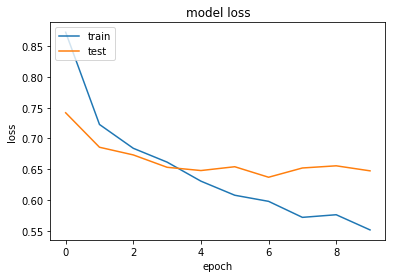

Fold 4 started at Thu Apr 11 08:58:06 2019
single model train loss: 
0.5492246323823928
single model validation loss: 
0.6345237191597096
single model dev loss: 
0.6342708733051319


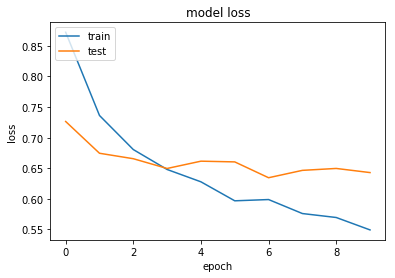

cv model accuracy: 
0.6206922321353556


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

In [27]:
# Training and cross-validation
dummy_X = np.zeros(shape=(train_df.shape[0], 1))

folds = KFold(n_splits=n_fold, shuffle=False, random_state=3)
is_first_fold = True
preds_train = list()
preds_dev = None
preds_test = None
for fold_n, (train_index, val_index) in enumerate(folds.split(dummy_X)):
    # split training and validation data
    print('Fold', fold_n, 'started at', time.ctime())
    
    Xt = [XX[train_index] for XX in X_train]
    Xv = [XX[val_index] for XX in X_train]
    
    yt = y_train.values[train_index]
    yv = y_train.values[val_index]
    
    model = build_mapmlp_model(
    num_channels1, num_channels2, num_channels3, 
    num_features1, num_features2, num_features3, 
    feature_dim1, output_dim, model_dim1, model_dim2, mlp_dim, 
    mlp_depth=mlp_depth, embed_dropout1=embed_dropout1, embed_dropout2=embed_dropout2, drop_out=drop_out, 
    return_customized_layers=return_customized_layers
    )
    
    adam = ko.Nadam()
    model.compile(adam, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

    early_stop = kc.EarlyStopping(monitor = "val_loss", mode = "min", patience=3, restore_best_weights=True)
    history = model.fit(Xt, yt, epochs=epochs, validation_data=(Xv, yv), callbacks = [early_stop], verbose=0, batch_size=32)
    
    preds_train_tmp = model.predict(Xv)
    preds_dev_tmp = model.predict(X_dev)
    preds_test_tmp = model.predict(X_test)
    
    print("single model train loss: ")
    print(history.history['loss'][-1])
    print("single model validation loss: ")
    print(measure_log_loss(yv, preds_train_tmp))
    print("single model dev loss: ")
    print(measure_log_loss(y_dev.values, preds_dev_tmp))
    
    
    fig = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig.savefig(model_name + '_lossplot.png')
    #plt.close(fig)
    
    if is_first_fold:
        preds_train.append(preds_train_tmp)
        preds_dev = preds_dev_tmp
        preds_test = preds_test_tmp
    else:
        preds_train.append(preds_train_tmp)
        preds_dev += preds_dev_tmp
        preds_test += preds_test_tmp
        
    is_first_fold = False

preds_train = np.concatenate(preds_train)
preds_dev /= n_fold
preds_test /= n_fold
print("cv model accuracy: ")
print(measure_log_loss(y_dev.values, preds_dev))

add_results(train_df, preds_train)
add_results(dev_df, preds_dev)
add_results(test_df, preds_test)
train_file_name = model_name + "_train.csv"
dev_file_name = model_name + "_dev.csv"
test_file_name = model_name + "_test.csv"

train_df.to_csv(train_file_name, index=False)
dev_df.to_csv(dev_file_name, index=False)
test_df.to_csv(test_file_name, index=False)

drop_results(train_df)
drop_results(dev_df)
drop_results(test_df)